In [281]:
# Reload all modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:
import re
import json
import glob
import cProfile
from urllib.parse import urljoin
import requests
from pathlib import Path
from tqdm import tqdm
from bs4 import BeautifulSoup
import roman
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import osmnx as ox

import src.data.parse_html as parse_html
import src.data.metadata as metadata
import src.data.token_counts as token_counts

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
proj_path = Path(os.environ['PROJ_DIR'])
data_dir = proj_path / 'data'
interim_data = data_dir / 'interim'
letters_path = data_dir / 'external' / 'Cartas-txt'
legal_docs_path = data_dir / 'external' / 'documentos arreglados CorpMA'

In [6]:
corpus_metadata = {
    'corpusmallorca':
        {
            'base_url': 'https://corpusmallorca.es',
            'remote_doc_list': 'buscar.php?&paleografica=on&critica=on&maxFiles=999999&nFilei=0&nFilef=1000&selDonde=0',
        },
    'corpuscodea':
        {
            'base_url': 'https://corpuscodea.es/corpus',
            'remote_doc_list': 'consultas.php',
            'local_doc_list': 'docs.html'
        },
    'corpuscharta':
        {
            'base_url': 'https://www.corpuscharta.es',
            'remote_doc_list': 'consultas.html',
            'local_doc_list': 'docs.html',
        },
}

# Load pre-processed data

In [ ]:
corpus_name = 'corpuscharta'
# corpus_name = 'corpuscodea'
corpus_dir = interim_data / corpus_name

In [ ]:
records = []
for path in corpus_dir.glob('*.json'):
    with open(path) as f:
        records.append(json.load(f))
auto_df = pd.DataFrame.from_records(records)
auto_df = auto_df.set_index('meta_id')
auto_df = metadata.normalize(auto_df)
auto_df.head()

,abstract,country,region,locality,century,archive,nr_words,copyist,raw_text,text,year,doc_type
meta_id,,,,,,,,,,,,
CORHEN-0029,Donación\n sub modo de Sancha Seménez a favor ...,España,Burgos,Riolacedo,XII,Archivo Histórico Nacional,417,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n Quoniam inter cetera pietatis opera; maxim...,1199.0,cartas de compraventa y contratos
CODCAR-0480,El\n infante don Sancho ordena a los merinos d...,España,Valladolid,S.Pbl.,XIII,Archivo de la Catedral de Burgos,260,Roy Martínez,"<td class=""textopaleo""><img class=""img-facsimi...",\n De mj jnffante don Sancho ffijo mayor & he...,1282.0,textos legislativos
CODCAR-0648,Ante\n la reclamación del obispo de Burgos de ...,España,Burgos,Quintanadueñas,XIII,Archivo de la Catedral de Burgos,3898,Joán Ferrández,"<td class=""textopaleo""><img class=""img-facsimi...",\n Don Sancho por la gracia de dios Rey de Ca...,1294.0,textos legislativos
CODEA-0688,Carta de cambio de posesiones entre el convent...,España,La Rioja,Cañas,XIII,Archivo Histórico Nacional,163,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n Conosçuda cosa ssea a quantos omnes esta c...,1292.0,cartas de compraventa y contratos
CORHEN-0106,Contrato\n de mañería por el que el concejo de...,España,Burgos,Tamayo,XII,Archivo Histórico Nacional,230,s.cop.,"<td class=""textopaleo""><img class=""img-facsimi...",\n JN nomine dominj nostri ihesu xpisti. Notu...,1194.0,cartas de compraventa y contratos


Load all documents

In [34]:
corpus_name = 'all'
list_df = []
for c in corpus_metadata.keys():
    corpus_dir = interim_data / c
    records = []
    for path in corpus_dir.glob('*.json'):
        with open(path) as f:
            records.append(json.load(f))
    df = pd.DataFrame.from_records(records)
    df = df.loc[df['text'].notnull()].set_index('meta_id')
    df = metadata.normalize(df)
    df['corpus'] = c
    list_df.append(df)
auto_df = pd.concat(list_df, axis=0, join='inner')

In [38]:
# remove duplicates between codea and charta
auto_df = auto_df.groupby('meta_id').first()

In [39]:
auto_df['is_private'] = auto_df['doc_type'].isin(['cartas privadas', 'cartas particulares'])

In [40]:
df['region'].value_counts().head(20)

Burgos         366
Valladolid     234
Sevilla        167
Málaga         132
Toledo         105
Palencia        91
León            65
Salamanca       64
Guadalajara     64
Ávila           61
S.Pr.           53
Cantabria       49
Asturias        46
Zamora          44
Segovia         42
La Rioja        42
Mérida          39
Teruel          36
Madrid          35
Zaragoza        34
Name: region, dtype: int64

# Compare manually and automatically cleaned texts

In [ ]:
manual_docs = {}
for fpath in letters_path.iterdir():
    match = re.match(r'.*_Lit \((.+)\)', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
    with open(fpath, 'r') as f:
        manual_docs[doc_id] = f.read()

In [ ]:
manual_docs = {}
for fpath in legal_docs_path.iterdir():
    match = re.match(r'(.+)p.txt', fpath.name)
    if match is not None:
        doc_id = match.groups()[0]     
        with open(fpath, 'r', encoding='Windows-1252') as f:
            manual_docs[doc_id] = f.read()

In [ ]:
for doc_id, text_by_hand in manual_docs.items():
    path = interim_data / f'{doc_id}.json'
    if path.exists():
        with open(interim_data / f'{doc_id}.json', 'r') as f:
            text_auto = json.load(f)['text']
        print(f'** {doc_id} **')
        print(text_by_hand)
        print(text_auto)
        break

this is a mess, nothing corresponds

In [ ]:
real_id = 'AMPO01_01'
manual_id = 'AMPO01_03'
text_by_hand = manual_docs[manual_id]
with open(interim_data / f'{real_id}.json', 'r') as f:
    text_auto = json.load(f)['text']
print(f'** {doc_id} **')
print(text_by_hand)
print(text_auto)

did it with AMPO01_01, which corresponds partly to AMPO01_03 (last paragraph), and removing \n and spaces, I get exact match

# Get places locations

In [ ]:
from collections import defaultdict
places = defaultdict(lambda: 0)
places_dict = {}
for doc_id in doc_ids:
    with open(interim_data / f'{doc_id}.json', 'r') as f:
        p = json.load(f)['place']
        places[p] += 1
        places_dict[doc_id] = p

In [ ]:
tags = {'place': 'city'}
gdf = ox.geometries_from_place('Madrid, Madrid', tags)
gdf

/home/thomaslouf/.conda/envs/cafeconmiel/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


,,admin_level,capital,ele,is_capital,name,name:ab,name:am,name:an,name:ar,name:arc,...,source,source:date,source:ele,source:file,source:name,source:name:oc,source:population,wikidata,wikipedia,geometry
element_type,osmid,,,,,,,,,,,,,,,,,,,,,
node,21068295,2,yes,655,country,Madrid,Мaдрид,ማድሪድ,Madrit,مدريد,ܡܕܪܝܕ,...,Instituto Geográfico Nacional,2011-06,MDT5,http://centrodedescargas.cnig.es/CentroDescarg...,Nomenclátor Geográfico de Municipios y Entidad...,Lo Congrès,"BOE REAL DECRETO 1683/2007, de 14 de diciembre",Q2807,es:Madrid,POINT (-3.70358 40.41670)


# Quick viz

In [41]:
# doc_df = auto_df[['doc_type', 'year', 'text'] + place_cols].copy()
doc_df = auto_df.copy()

In [ ]:
figs_path = proj_path / 'reports' / 'figures' / corpus_name
figs_path.mkdir(parents=True, exist_ok=True)

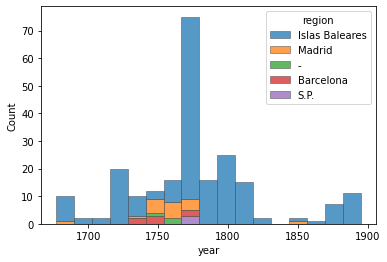

In [ ]:
top_regions = doc_df.groupby('region').size().sort_values().tail(5).index
ax = sns.histplot(
    doc_df.loc[doc_df['region'].isin(top_regions)].drop_duplicates(),
    x="year", hue="region",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
ax.get_figure().savefig(figs_path / 'year_hist_by_region.pdf')

legal docs will most probably be useless, first for their content bu also region distribution: almost exclusively in baleares

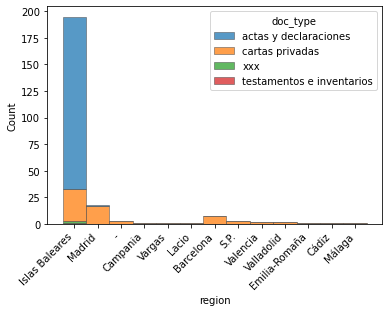

In [ ]:
ax = sns.histplot(
    doc_df.drop_duplicates(),
    x="region", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_horizontalalignment('right')

ax.get_figure().savefig(figs_path / 'region_hist_by_doc_type.pdf', bbox_inches='tight')

however letters have very small year range

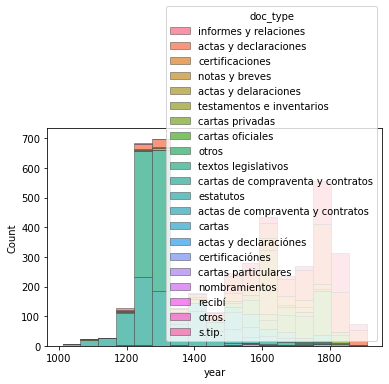

In [42]:
ax = sns.histplot(
    doc_df.drop_duplicates(),
    x="year", hue="doc_type",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_by_doc_type.pdf')

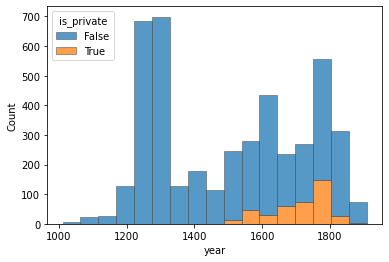

In [43]:
ax = sns.histplot(
    doc_df.drop_duplicates(),
    x="year", hue="is_private",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_private_or_not.pdf')

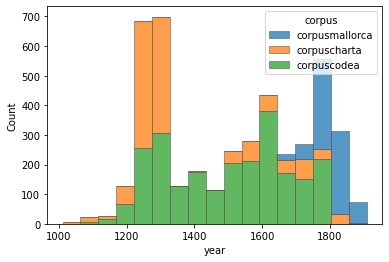

In [44]:
ax = sns.histplot(
    doc_df,
    x="year", hue="corpus",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
)
# ax.get_figure().savefig(figs_path / 'year_hist_corpus.pdf')

# Word counts

## Pre-process

In [181]:
doc_df = auto_df.copy()
word_patt = re.compile(r'\b[^\W\d_]+?\b')
# doc_type_mask = doc_df['doc_type'] == 'cartas privadas'
doc_type_mask = ~doc_df['is_private']
years_mask = (doc_df['year'] >= 1700) & (doc_df['year'] < 1800)
doc_mask = doc_type_mask & years_mask
doc_df['is_BA'] = doc_df['region'] == 'Islas Baleares'

In [188]:
words_count_by_doc = token_counts.count_by_doc(doc_df.loc[doc_mask])
words_count_by_doc.head()

count word_lower
meta_id  word                       
AA001_01 Altissimm      1  altissimm
         Anno           1       anno
         Audiencia      3  audiencia
         Augusti        1    augusti
         C              1          c

## Global

In [189]:
global_counts = token_counts.doc_counts_to_global(words_count_by_doc)
global_counts.head()

,count,count_upper,prop_upper,nr_docs,doc_freq
word_lower,,,,,
de,21965,309,0.014068,512,0.988417
y,17617,1099,0.062383,507,0.978764
que,13757,401,0.029149,498,0.961390
la,8428,287,0.034053,484,0.934363
en,8111,654,0.080631,498,0.961390


## Filtered counts

In [197]:
global_counts = token_counts.word_mask(global_counts, min_df=5, max_df=0.5, upper_th=0.4)
print(global_counts['word_mask'].sum())
normed_words_count_by_doc = token_counts.filter_doc_counts(
    words_count_by_doc, global_counts['word_mask']
)
normed_words_count_by_doc.head()

2821


count  word_mask
meta_id  word_lower                    
AA001_01 caido             1       True
         cantidad          1       True
         consequencia      1       True
         consta            2       True
         copia             1       True

### By doc

In [289]:
word_counts_mat = normed_words_count_by_doc['count'].unstack().fillna(0).astype(int)

In [290]:
(word_counts_mat.T / word_counts_mat.sum(axis=1))

meta_id,AA001_01,AA001_02,AA001_03,AA001_04,AA002_01,AA002_02,AA002_03,AA002_04,AA002_5,AA003_01,...,NOT01_05,NOT01_06,NOT01_07,NOT02_02,NOT03_01,NOT03_02,NOT03_03,SAL01_01,SAL01_02,SAL01_03
word_lower,,,,,,,,,,,,,,,,,,,,,
abajo,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0033,0.0,0.000000,0.0,0.0,0.000000,0.000000
aber,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
abra,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
abran,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
absoluto,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ò,0.0,0.000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
ó,0.0,0.016,0.0,0.017361,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0000,0.0,0.000000,0.0,0.0,0.000000,0.000000
ô,0.0,0.000,0.0,0.000000,0.006173,0.0,0.002789,0.000000,0.0,0.0,...,0.027344,0.010695,0.0,0.0033,0.0,0.002801,0.0,0.0,0.007657,0.004695


### By region

In [ ]:
normed_words_count_by_reg = normed_words_count_by_doc.join(doc_df['region'], on='meta_id').groupby(['word_lower', 'region'])[['count']].sum()

In [ ]:
word_counts_mat = normed_words_count_by_reg['count'].unstack().fillna(0).astype(int)

In [ ]:
bal_col = 'Islas Baleares'
reg_not_bal = [reg for reg in word_counts_mat.columns if reg != bal_col]
word_counts_mat['not_bal'] = word_counts_mat.loc[:, reg_not_bal].sum(axis=1)
# word_vec_out = word_counts_mat.loc[:, ('count', reg_not_bal)].values.sum(axis=1)
# word_vec_in = word_counts_mat.loc[:, ('count', bal_col)].values

In [ ]:
word_counts_mat['total'] = global_counts['count']

In [ ]:
word_prop_mat = word_counts_mat / word_counts_mat.sum(axis=0)

In [ ]:
mask = word_counts_mat['total'] > 50
polar = ((word_prop_mat[bal_col] - word_prop_mat['not_bal']) / (word_prop_mat[bal_col] + word_prop_mat['not_bal'])).loc[mask]

In [ ]:
polar.sort_values(ascending=False, key=np.abs).head(50)

word_lower
vuestras   -1.000000
señorias   -1.000000
señoria    -0.808807
don        -0.659074
vuestra    -0.612516
mui        -0.609097
pies       -0.609097
villa       0.563630
dela       -0.520326
tan        -0.501745
señor      -0.492632
nuestro    -0.480056
â           0.474722
à          -0.443733
ella       -0.421856
da          0.388267
puede      -0.386599
merced     -0.370433
ciudad     -0.368921
a          -0.363963
á           0.357887
ser         0.335914
nos        -0.316384
he         -0.306460
pues       -0.287055
las         0.271475
yo          0.267360
carta      -0.252183
v           0.238037
ya          0.228563
sra         0.228563
pero        0.216531
sus         0.215539
tiene      -0.211018
señora     -0.208841
se          0.200367
deseo       0.190302
señores    -0.188688
dn         -0.178727
por         0.175596
es         -0.166162
muy         0.164401
los         0.158114
no          0.155237
casa        0.148049
mas         0.145483
sin        -0.142348
de

-> 2 distribs, difference into PCA?

'â' in bold in texts for some reason

## Character ngrams

In [295]:
ngram_doc_counts = token_counts.char_ngrams(
    normed_words_count_by_doc, global_counts, min_n=2, max_n=3
)
ngram_doc_counts.head()

count
meta_id  char_ngram       
AA001_01 ac              1
         aci             1
         ad              4
         ado             3
         ag              1

# Classification

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [358]:
# doc_counts = ngram_doc_counts
doc_counts = normed_words_count_by_doc

In [360]:
counts_mat, docs, tokens = doc_counts['count'].astype('Sparse').sparse.to_coo(sort_labels=True)
# docs = counts_mat_df.columns
clustering_df = doc_df.loc[docs].copy()
labels = clustering_df['is_BA'].astype(int)
true_k = 2
n_components = 10

upper_th = 0.4
print("Extracting features from the training dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(
    # analyzer='char_wb',
    max_df=0.5,
    token_pattern=r'\b[^\W\d_]+?\b',
    vocabulary=global_counts.loc[global_counts['prop_upper'] < upper_th].index,
    # max_features=opts.n_features,
    min_df=5,
    use_idf=True,
    # ngram_range=(2,3),
)
# X = vectorizer.fit_transform(clustering_df['text'].values)
# X = (word_counts_mat / word_counts_mat.sum(axis=0)).values.T
X = counts_mat
transformer = TfidfTransformer(use_idf=True, smooth_idf=False)
X = transformer.fit_transform(X)

print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

Extracting features from the training dataset using a sparse vectorizer
n_samples: 512, n_features: 2821

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 15%


## Unsupervised clustering

In [361]:
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering

In [362]:
km = KMeans(
    n_clusters=true_k,
    # init="k-means++",
)

print("Clustering sparse data with %s" % km)
km.fit(X)
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted MI: %.3f" % metrics.adjusted_mutual_info_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_)
)

print("Top tokens per cluster:")

if n_components:
    original_space_centroids = svd.inverse_transform(km.cluster_centers_)
else:
    original_space_centroids = km.cluster_centers_
dist = (original_space_centroids[0] - original_space_centroids[1])**2
order_centroids = original_space_centroids.argsort()[:, ::-1]
# tokens = vectorizer.get_feature_names_out()

for i in range(true_k):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :20]:
        print(" %s" % tokens[ind], end="")
    print()

Clustering sparse data with KMeans(n_clusters=2)

Homogeneity: 0.423
Completeness: 0.458
V-measure: 0.440
Adjusted MI: 0.439
Adjusted Rand-Index: 0.472
Silhouette Coefficient: 0.157
Top tokens per cluster:
Cluster 0: â á mi à ha dela si ante dixo una me casa doy parte un verdad auto testigo declarante ni
Cluster 1: dela acordo mi deesta rexidores maior vn vna dos sus mill dijo sobre vno fee derecho lugar poder ella desta


Check if words are not from text processing mistake:

In [253]:
word = 'deella'
doc_df.loc[(doc_df['text'].str.contains(word)) & (~doc_df['raw_text'].str.contains(word))]

,archive,year,locality,region,country,abstract,doc_type,raw_text,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,,,


In [363]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(labels.values, km.labels_)
label_swapped = confusion[0, 0] + confusion[1, 1] < confusion[0, 1] + confusion[1, 0]
if label_swapped:
    confusion = confusion[::-1, :]
print(f'True BAL: {confusion[1, 1]}, True notBAL: {confusion[0, 0]}, False BAL: {confusion[0, 1]}, False notBAL: {confusion[1, 0]}, ')

True BAL: 166, True notBAL: 266, False BAL: 6, False notBAL: 74, 


In [269]:
precision = confusion[1,1] / (confusion[1,1] + confusion[0,1])
recall = confusion[1,1] / (confusion[1,1] + confusion[1,0])
accuracy = (confusion[1,1] + confusion[0,0]) / confusion.sum()
print(precision, recall, accuracy)

0.9109947643979057 0.6397058823529411 0.7745098039215687


# Supervised classification

In [364]:
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier

In [368]:
res = sklearn.model_selection.cross_validate(
    RandomForestClassifier(),
    X,
    labels,
    cv=10,
    return_estimator=True,
)
print(res)

{'fit_time': array([0.29208875, 0.26724076, 0.26315665, 0.2586565 , 0.25795627,
       0.26017666, 0.26240444, 0.26485944, 0.26420474, 0.30622363]), 'score_time': array([0.01725101, 0.01633787, 0.01654601, 0.01641726, 0.01643968,
       0.0165236 , 0.01688671, 0.01664543, 0.01685333, 0.01962209]), 'estimator': [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()], 'test_score': array([0.76923077, 0.84615385, 0.8627451 , 0.76470588, 0.82352941,
       0.74509804, 0.78431373, 0.98039216, 1.        , 0.90196078])}


In [384]:
for est in res['estimator']:
    top_features = np.argsort(est.feature_importances_)[::-1]
    if n_components:
        top_comp = svd.components_[top_features[0], :]
        top_words = [tokens[i] for i in np.argsort(top_comp)[::-1][:20]]
    else:
        top_words = [tokens[i] for i in top_features[:20]]
    print(top_words)

['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supiere', 'alias', 'cita', 'declaracion', 'ante', 'señal', 'edad', 'ço', 'fecho', 'ratifica', 'afirma']
['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supiere', 'alias', 'cita', 'declaracion', 'ante', 'señal', 'edad', 'ço', 'fecho', 'ratifica', 'afirma']
['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supiere', 'alias', 'cita', 'declaracion', 'ante', 'señal', 'edad', 'ço', 'fecho', 'ratifica', 'afirma']
['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supiere', 'alias', 'cita', 'declaracion', 'ante', 'señal', 'edad', 'ço', 'fecho', 'ratifica', 'afirma']
['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supiere', 'alias', 'cita', 'declaracion', 'ante', 'señal', 'edad', 'ço', 'fecho', 'ratifica', 'afirma']
['â', 'testigo', 'dixo', 'decir', 'verdad', 'sabe', 'dixó', 'cargo', 'firmó', 'supier

In [385]:
doc_df.loc[doc_df['text'].str.contains('dixo')]

,archive,year,locality,region,country,abstract,doc_type,raw_text,text,corpus,is_private,is_BA
meta_id,,,,,,,,,,,,
AA004,None,NaN,None,None,None,"Declaración de Jorge Ramis, el cual narra todo...",actas y declaraciones,"<td class=""textopaleo""><br/><a <="""" href=""facs...",\n Dia 6 Noviembre 1760. \n Jorge Ramis natu...,corpusmallorca,False,False
AA004_03,Arxiu del Regne de Mallorca,1760.0,Palma,Islas Baleares,España,Declaraciones de Pedro Antonio Bonet y Antonio...,actas y declaraciones,{h 4v} |…| [margen: Tes<timoni>o 2º | Declara<...,|…| ] En Dicha Ciudad de Palma a 7 Dias del\n...,corpusmallorca,False,True
AA006_02,Arxiu del Regne de Mallorca,1769.0,Felanitx,Islas Baleares,España,Vecinos de Felanitx declaran ante Antonio Flux...,actas y declaraciones,{h 6r} |...| [margen: 1 | Declaracion | de Bar...,|...| En la propria villa de Felanitx â siet...,corpusmallorca,False,True
AA006_03,Arxiu del Regne de Mallorca,1769.0,Felanitx,Islas Baleares,España,Continúan las declaraciones de vecinos de Fela...,actas y declaraciones,{h 12v} |...| [margen: 7 | Declaracion de | Mi...,|...| En la propia Villa a ocho dias de dich...,corpusmallorca,False,True
AA006_04,Arxiu del Regne de Mallorca,1769.0,Felanitx,Islas Baleares,España,Continúan las declaraciones de vecinos de Fela...,actas y declaraciones,{h 17r} |...| [margen: 13 | Declaracion | de S...,|...| En la propia Villa â nueve dias de dic...,corpusmallorca,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
NOT01_02,Arxiu del Regne de Mallorca,1735.0,Palma,Islas Baleares,España,Bartolomé Peregrín otorga un poder a Pedro Mar...,certificaciones,{h 73r} [margen / lat: ff<irmatu>m cu<m> pap<e...,Sepan todos quantos esta carta de poder vier...,corpusmallorca,False,True
NOT01_04,Arxiu del Regne de Mallorca,1742.0,Palma De Mallorca,Islas Baleares,España,Certificado de testimonios hechos ante el nota...,certificaciones,h 169r [margen: copia die | february 1742 | cu...,h 169r En la ciudad de Palma de el Reyno de \...,corpusmallorca,False,True
NOT01_05,Arxiu del Regne de Mallorca,1742.0,Palma,Islas Baleares,España,Borrador de un documento por el que Jerónimo d...,certificaciones,{h 173r} En la Ciud<ad> de Palma de el Reyno d...,En la Ciudad de Palma de el Reyno de Mallorca...,corpusmallorca,False,True


In [373]:
est.feature_importances_

array([0.11791561, 0.3747353 , 0.06972618, 0.11959468, 0.07231981,
       0.04245561, 0.04725103, 0.07186299, 0.03512225, 0.04901655])

In [377]:
tokens

['abajo',
 'aber',
 'abra',
 'abran',
 'absoluto',
 'abundamiento',
 'aca',
 'acaba',
 'acabo',
 'acaso',
 'acatamiento',
 'acauo',
 'accidente',
 'accidentes',
 'accion',
 'acciones',
 'acia',
 'aciento',
 'acompaña',
 'acompañada',
 'acompañado',
 'acompañen',
 'acordado',
 'acordaron',
 'acordava',
 'acordo',
 'acordó',
 'acostumbra',
 'acostumbrada',
 'acostumbrado',
 'acostumbrava',
 'acredita',
 'acto',
 'actos',
 'actuado',
 'actual',
 'actuales',
 'actualidad',
 'actualmente',
 'acudido',
 'acudieron',
 'acudio',
 'acudir',
 'acuerda',
 'acusacion',
 'acustrumbrados',
 'ad',
 'adelante',
 'ademas',
 'adicha',
 'adicho',
 'administra',
 'administrado',
 'administrados',
 'administrar',
 'administre',
 'admita',
 'admite',
 'admitido',
 'admitio',
 'admitir',
 'adonde',
 'adquirido',
 'adversa',
 'ael',
 'aesta',
 'aeste',
 'afin',
 'afirma',
 'afirmava',
 'afirmo',
 'afirmó',
 'aga',
 'agarrados',
 'agarro',
 'agrado',
 'agua',
 'aguardando',
 'aguardar',
 'aguardiente',
 'ahora